In [1]:
import sys
sys.path.append('../')

import numpy as np
from cpat import Compatibility, init_cpat, train_cpat
from bproj import BaryProj, init_bproj, train_bproj
from score import Score, init_score, train_score
from scones import SCONES
import matplotlib.pyplot as plt
from config import Config
from datasets import Gaussian, SwissRoll
import json
import torch
import os
from sinkhorn import sample_stats, sq_bw_distance, sinkhorn, bw_uvp
from collections import defaultdict
'''
Given a configuration, train SCONES and BP and output
'''
cnf = Config("Swiss-Roll",
             source="circle",
             target="swiss-roll",
             l = 2,
             cpat_lr=0.00001,
             cpat_iters=2500,
             cpat_bs=1000,
             score_lr=0.000001,
             score_iters=2500,
             score_bs=1000,
             bproj_lr=0.000001,
             bproj_iters=5000,
             bproj_bs=1000,
             score_noise_init=5,
             score_noise_final=0.01,
             device='cuda',
             score_n_classes = 20,
             score_steps_per_class = 400,
             score_sampling_lr = 0.000001,
             scones_samples_per_source=100,
             seed=2039)
torch.manual_seed(cnf.seed)
np.random.seed(cnf.seed)
import time
log_dir = 'logs/' + time.strftime("%Y-%m-%d/%H_%M_%S/", time.localtime())
cnf.log_dir = log_dir

In [2]:
cnf.__dict__

{'name': 'Swiss-Roll',
 'source_dist': <datasets.Circle at 0x7fd4bdb63d10>,
 'target_dist': <datasets.SwissRoll at 0x7fd4bd30b050>,
 'source_dim': 2,
 'target_dim': 2,
 'l': 2,
 'cpat_lr': 1e-05,
 'cpat_iters': 2500,
 'cpat_bs': 1000,
 'bproj_lr': 1e-06,
 'bproj_iters': 5000,
 'bproj_bs': 1000,
 'score_lr': 1e-06,
 'score_iters': 2500,
 'score_bs': 1000,
 'score_n_classes': 20,
 'score_steps_per_class': 400,
 'score_sampling_lr': 1e-06,
 'score_noise_init': 5,
 'score_noise_final': 0.01,
 'scones_iters': 3000,
 'scones_samples_per_source': 100,
 'scones_bs': 1000,
 'cov_samples': 10000,
 'device': 'cuda',
 'seed': 2039,
 'log_dir': 'logs/2023-07-24/21_09_53/'}

In [3]:
import wandb
run = wandb.init(
    project="scones",
    config=cnf.__dict__,
    save_code=True, 
    name=cnf.name+time.strftime("%Y-%m-%d/%H:%M:%S", time.localtime()),
    dir=log_dir
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jimmyisme. Use `wandb login --relogin` to force relogin
wandb: WARNING Path logs/2023-07-24/21_09_53/wandb/ wasn't writable, using system temp directory.


In [5]:
# rand_shuffling = np.random.permutation(20)

# initial = DiagonalMatching(500,mode='initial', easy=True).rvs((200, 0))[:20][rand_shuffling]
# final = DiagonalMatching(500,mode='final', easy=True).rvs((200, 0))[:20][rand_shuffling]
# plt.scatter(*initial.T)
# plt.scatter(*final.T)
# plot_matchings(initial, final, lw=.5)
# plt.show()

In [6]:
from  diagonal_matching import DiagonalMatching
cnf.source_dist = DiagonalMatching(n_samples=cnf.scones_samples_per_source, mode='initial',easy=True)
cnf.target_dist = DiagonalMatching(n_samples=cnf.scones_samples_per_source, mode='final', easy=True)

In [7]:
cpat = init_cpat(cnf)

# If TRUE, ignore any existing pretrained models and overwrite them.
OVERWRITE = True

# Create directories for saving pretrained models if they do not already exist
touch_path = lambda p: os.makedirs(p) if not os.path.exists(p) else None
for path in ['', 'cpat', 'bproj', 'ncsn']:
    touch_path(log_dir + path)

# Search for and load any existing pretrained models
if ((not OVERWRITE) and os.path.exists(os.path.join(f"{log_dir}cpat", cnf.name))):
    cpat.load(os.path.join(f"{log_dir}cpat", cnf.name, "cpat.pt"))
else:
    train_cpat(cpat, cnf, log_dir, run, verbose=True)

bproj = init_bproj(cpat, cnf)

if ((not OVERWRITE) and os.path.exists(os.path.join(f"{log_dir}bproj", cnf.name))):
    bproj.load(os.path.join(f"{log_dir}bproj", cnf.name, "bproj.pt"))
else:
    train_bproj(bproj, cnf, log_dir, run, verbose=True)

score = init_score(cnf)

if ((not OVERWRITE) and os.path.exists(os.path.join(f"{log_dir}score", cnf.name))):
    score.load(os.path.join(f"{log_dir}score", cnf.name, "score.pt"))
else:
    train_score(score, cnf, log_dir, run, verbose=True)

Objective: 5.64E-01: 100%|██████████| 2500/2500 [00:31<00:00, 80.17it/s]


In [9]:
scones = SCONES(cpat, score, bproj, cnf)

# Sample and test the model 
n_samples = 2000
Xs = cnf.source_dist.rvs(size=(n_samples,))
Xs_th = torch.FloatTensor(Xs).to(cnf.device)

bproj_Xs_th = bproj.projector(Xs_th).detach()
bproj_Xs = bproj_Xs_th.cpu().numpy()


scones_samples = scones.sample(Xs_th, verbose=True, source_init=True)

100%|██████████| 20/20 [6:40:22<00:00, 1201.10s/it]  


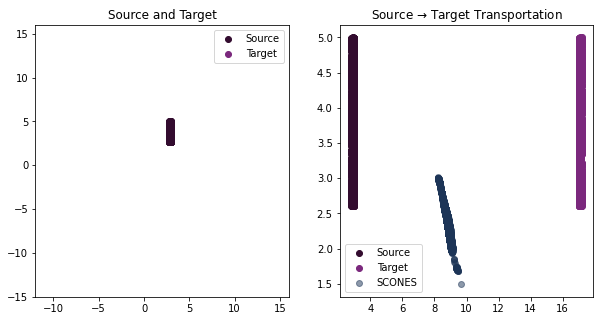

In [11]:
plt.subplot(1, 2, 1)
plt.scatter(*Xs.T, color="#330C2F", label="Source")
plt.scatter(*cnf.target_dist.rvs(size=(n_samples,)).T, color="#7B287D", label="Target")
plt.legend()
plt.ylim(-15, 16)
plt.xlim(-12, 16)
plt.title("Source and Target")

plt.subplot(1, 2, 2)
plt.scatter(*Xs.T, color="#330C2F", label="Source")
plt.scatter(*cnf.target_dist.rvs(size=(n_samples,)).T, color="#7B287D", label="Target")
# plt.scatter(*bproj_Xs.T, label="BPROJ", color="#7067CF", alpha=0.5)
plt.scatter(*scones_samples.reshape(-1, 2).T, label="SCONES", color="#1d3557", alpha=0.5)
# print(scones_samples.reshape(-1, 2)[0,:])
plt.legend()
# plt.ylim(-15, 16)
# plt.xlim(-12, 16)
plt.title("Source $\\to$ Target Transportation")

plt.gcf().set_size_inches(10, 5)
plt.savefig("Source_2_Target.png")
plt.show()

#np.save("Cutout_Bproj_Gaussian->SwissRoll.npy", bproj_Xs)
#np.save("Cutout_SCONES_Gaussian->SwissRoll.npy", scones_samples)
np.save("Cutout.npy", scones_samples)
np.save("Sources.npy", Xs)
np.save("Target.npy", cnf.target_dist.rvs(size=(n_samples,)))

In [ ]:
scones_samples.shape

(400, 100, 2)

In [12]:
def plot_matchings(fig, t0_points, t1_points, projection=lambda x: x, **kwargs):
    kwargs["color"] = kwargs.get("color", "gray")
    kwargs["alpha"] = kwargs.get("alpha", .7)
    # kwargs["lw"] = kwargs.get("lw", .2)
    extended_coords = np.concatenate([projection(t0_points), projection(t1_points)], axis=1)
    fig.plot(extended_coords[:,::2].T, extended_coords[:,1::2].T, zorder=0, **kwargs);
    
from matplotlib.colors import LinearSegmentedColormap
colors = ['#1A254B', '#114083', '#A7BED3', '#FFFFFF', '#F2545B', '#A4243B']
bcmap = LinearSegmentedColormap.from_list('bcmap', colors, N=100)

  0%|          | 0/20 [12:13:36<?, ?it/s]


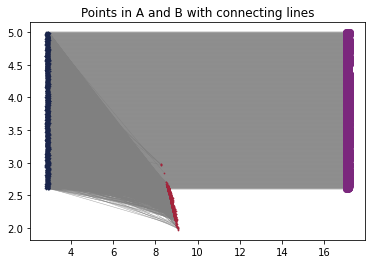

In [13]:
# Generating random points for A and B
A = Xs
B = scones_samples[:,0,:]
# plt.figure( figsize=(10,10), dpi=500)
# Plotting points in A and B
fig, ax = plt.subplots()
ax.scatter(A[:, 0], A[:, 1], color=colors[0], label='A', s=0.5)
ax.scatter(B[:, 0], B[:, 1], color=colors[-1], label='B', s=0.5)
plot_matchings(ax, A, B, lw=.5)

# ax.scatter(*Xs.T, color="#330C2F", label="Source")
ax.scatter(*cnf.target_dist.rvs(size=(n_samples,)).T, color="#7B287D", label="Target")
plot_matchings(ax, Xs, cnf.target_dist.rvs(size=(n_samples,)), lw=.2)

# ax.legend()
# fig.xlabel('x')
# fig.ylabel('y')
ax.set_title('Points in A and B with connecting lines')
run.log(
    {
        'fig': wandb.Image(fig)
    }
)
fig.savefig('arrow.jpg')
fig.show()